In [18]:
import numpy as np
import tensorflow as tf
from utility import *
import matplotlib.pyplot as plt
from matplotlib import colors
import os
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/watson/scripts/virt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'diff', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X_orig, y_orig = loadData()

(6053, 6084)


In [3]:
X_orig = np.array(X_orig).reshape(-1, 23, 23, 1)
y_orig = np.array(y_orig)
X_orig = (X_orig - X_orig.mean() )/ X_orig.std()
X_total = X_orig[:100000]
y_total = y_orig[:100000]
X_train = X_total[:70000]
y_train = y_total[:70000]
X_val = X_total[70000:]
y_val = y_total[70000:]
print(X_train.shape)
print(y_train.shape)

(70000, 23, 23, 1)
(70000,)


In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 23, 23, 1])
y = tf.placeholder(tf.float32, [None])
is_training = tf.placeholder(tf.bool)

def myModel(X, y):
    Wconv1 = tf.get_variable("Wconv1", shape=[3, 3, 1, 23])
    bconv1 = tf.get_variable("bconv1", shape=[23])
    Wconv2 = tf.get_variable("Wconv2", shape=[3, 3, 23, 23])
    bconv2 = tf.get_variable("bconv2", shape=[23])
    W1 = tf.get_variable("W1", shape=[8303, 10])
    b1 = tf.get_variable("b1", shape=[10])
    W2 = tf.get_variable("W2", shape=[10, 1])
    b2 = tf.get_variable("b2", shape=[1])
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding="VALID") + bconv1
    h1 = tf.nn.relu(a1)
    a2 = tf.nn.conv2d(h1, Wconv2, strides=[1, 1, 1, 1], padding="VALID") + bconv2
    h2 = tf.nn.relu(a2)
    h2_flat = tf.reshape(h2, [-1, 8303])
    h3 = tf.matmul(h2_flat, W1) + b1
    y_out = tf.matmul(h3, W2) + b2
    return y_out

y_out = myModel(X, y)

diff = y - y_out
mean_loss = tf.reduce_mean(tf.pow(y_out - y,2))

optimizer = tf.train.AdamOptimizer(5e-2)
train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 1.68e+08
Iteration 100: with minibatch training loss = 1.1e+07
Iteration 200: with minibatch training loss = 6.38e+08
Iteration 300: with minibatch training loss = 2.74e+09
Iteration 400: with minibatch training loss = 2.11e+08
Iteration 500: with minibatch training loss = 5.3e+06
Iteration 600: with minibatch training loss = 1.7e+08
Iteration 700: with minibatch training loss = 1.71e+08
Iteration 800: with minibatch training loss = 5.66e+06
Iteration 900: with minibatch training loss = 7.94e+08
Iteration 1000: with minibatch training loss = 1.74e+06
Epoch 1, Overall loss = 4.39e+08


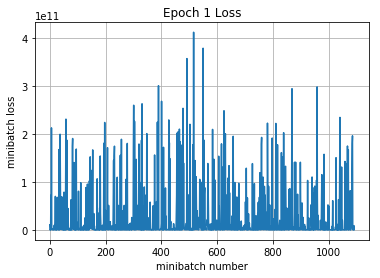

Validation
Epoch 1, Overall loss = 2.05e+08


In [17]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=2000, print_every=100,
              training=None, plot_losses=False):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, mean_loss]
    if training_now:
        variables[-1] = training
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(total_loss,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)